Script used to compute the values used in Fig5 (and also in some validation plots used in my thesis but excluded from the paper manuscript). Figure in this script was used in the thesis to understand the spatial distribution of cross-isobath transports, in the paper I only look at the circumpolar mean.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from gsw import SA_from_SP, p_from_z, CT_from_pt, sigma1
## once you've set up a dask-worker in the terminal, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [40]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
from matplotlib.transforms import offset_copy

In [2]:
from matplotlib import rc, rcParams
import cmocean.cm as cmo
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 
rc('text', usetex=True)
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)

In [5]:
expt = '01deg_jra55v13_ryf8485_spinup6'
save_dir = '/g/data/v45/rm2389/Isobath_Transport/control/'
timeslice = slice('1946-05','1947-05') # a year with daily data
latslice = slice(-90,-59)
n_bound = None

Wont actually run the procedure below, it takes a while. But that's how the required output is generated.

```
## some grid data is required, a little complicated because these variables don't behave well with some 
dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')

## the values below were all generated by Adele's isobath function find -contour.py
slope_data = xr.open_dataset('tools/Antarctic_slope_contour_1000m.nc',chunks = {'xt_ocean':600})
mask_y_transport = slope_data.mask_y_transport
mask_x_transport = slope_data.mask_x_transport
mask_y_transport_numbered = slope_data.mask_y_transport_numbered
mask_x_transport_numbered = slope_data.mask_x_transport_numbered
## slice slope data
latslice = slice(-80.02, -59)
mask_y_transport = mask_y_transport.sel(yt_ocean =latslice)
mask_x_transport = mask_x_transport.sel(yt_ocean = latslice)
mask_y_transport_numbered = mask_y_transport_numbered.sel(yt_ocean = latslice)
mask_x_transport_numbered = mask_x_transport_numbered.sel(yt_ocean = latslice)
## now for the daily model output
# vhrho refers to meridional transport across the northern edge of a tracer cell
vhrho = cc.querying.getvar(expt, 'vhrho_nt', session)
# uhrho refers to zonal transport across the eastern edge of a tracer cell
uhrho = cc.querying.getvar(expt, 'uhrho_et', session)
# tracer values are (for now) left unchunked in horizontal coordinates as they will later be interpolated onto an 
# alternate grid and chunking prevents this
temp = cc.querying.getvar(expt, 'temp', session, ncfile = 'ocean_daily_3d_temp_%%.nc', n=n_bound, chunks = {'yt_ocean':None, 'xt_ocean':None})
salt = cc.querying.getvar(expt, 'salt', session, ncfile = 'ocean_daily_3d_salt_%%.nc', n=n_bound, chunks = {'yt_ocean':None, 'xt_ocean':None})
## need to avoid chunking on the lateral dimensions along which we will interpolate
vhrho = vhrho.sel(time = timeslice, yt_ocean = latslice)
uhrho = uhrho.sel(time = timeslice, yt_ocean = latslice)
temp = temp.sel(time = timeslice, yt_ocean = latslice)
salt = salt.sel(time = timeslice, yt_ocean = latslice)
dyt = dyt.sel(yt_ocean = latslice)
dxu = dxu.sel(yu_ocean = latslice)

## the yt_ocean_sub01 dimension (associated with the daily data) has a bunch of zeros at the start 
## that makes slicing impossible -so here I replace the lat variable
## this needs to be done carefully:
#       vhrho is defined as the transport across the northern edge of a tracer 
#       cell to it's coordinates should be (yu_ocean, xt_ocean)
#       uhrho is defined as the transport across the eastern edge of a tracer
#       cell so it's coordinates should be (yt_ocean, xu_ocean)
#       however the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation and sorting possible

time = vhrho.time.values
st_ocean = vhrho.st_ocean.values

yt_ocean = dyt.yt_ocean.values
yu_ocean = dxu.yu_ocean.values
xu_ocean = dxu.xu_ocean.values
xt_ocean = dyt.xt_ocean.values
vhrho.coords['yt_ocean'] = yu_ocean
uhrho.coords['xt_ocean'] = xu_ocean
vhrho = vhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
uhrho = uhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})

dyt = dyt.reset_coords().dyt # remove geolon_t/geolat_t coordinates
dxu = dxu.reset_coords().dxu # remove geolon_t/geolat_t coordinates
dxu.coords['xu_ocean'] = xt_ocean
dxu = dxu.rename({'yu_ocean':'y_ocean', 'xu_ocean':'x_ocean'}) 
dyt.coords['xt_ocean'] = xu_ocean
dyt = dyt.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

## the same replacement of lat lon coordinates with those corresponding with the actual data location 
## is required for the mask_x/y_transport grids
## again do carefully:
#       the y masks refer to vhrho, so like vhrho this should have 
#       dimensions (yu_ocean, xt_ocean)
#       the x masks refer to uhrho, so like uhrho this should have 
#       dimensions (yt_ocean, xu_ocean)
#       however the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation and sorting possible

mask_y_transport.coords['yt_ocean'] = yu_ocean
mask_y_transport_numbered.coords['yt_ocean'] = yu_ocean
mask_x_transport.coords['xt_ocean'] = xu_ocean
mask_x_transport_numbered.coords['xt_ocean'] = xu_ocean

mask_y_transport = mask_y_transport.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
mask_y_transport_numbered = mask_y_transport_numbered.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
mask_x_transport = mask_x_transport.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})
mask_x_transport_numbered = mask_x_transport_numbered.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

## chunk everything to be identical (check for 1 timestep if this is a suitable chunking)
mask_x_transport = mask_x_transport.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
mask_y_transport = mask_y_transport.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
mask_x_transport_numbered = mask_x_transport_numbered.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
mask_y_transport_numbered = mask_y_transport_numbered.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
dxu = dxu.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
dyt = dyt.chunk(chunks = {'y_ocean':484, 'x_ocean':600})
vhrho = vhrho.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})
uhrho = uhrho.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})

## mask away all vhrho values less than -1e9 and multiply by dxu/1035
## since vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell
## since it's the NORTH edge - we need dx spacing on the u grid

mask = vhrho.where(vhrho>-1e19) *0 + 1
vhrho = vhrho * mask * dxu/1035

## mask away all uhrho values less than -1e9 and multiply by dyt/1035
## since uhrho_et is u*dz*1035 and is positioned on east centre edge of t-cell,
## since it's the MIDDLE of the edge, we need dy spacing on the t grid. here we convert to transport

mask = uhrho.where(uhrho>-1e19) *0 + 1
uhrho = uhrho * mask * dyt/1035
```

```
## create the isobath order data-array. Note that in this procedure the x-grid counts have x-grid
## dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
## *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
## but we dont double up with numerous counts for one lat/lon point

mask_x_numbered_1d = mask_x_transport_numbered.stack(isobath_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(isobath_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
isobath_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'isobath_index')
isobath_ordering = isobath_ordering.sortby(isobath_ordering)


#### GET LAT AND LON ALONG ISOBATH
## since the metadata is retain it is incredibly easy to extract lat/lon along isobath
lat_along_isobath = isobath_ordering.y_ocean
lon_along_isobath = isobath_ordering.x_ocean
isobath_index_array = np.arange(1,6003)
## don't need the multiindex anymore, replace with isobath count and save
lat_along_isobath.coords['isobath_index'] = isobath_index_array
lon_along_isobath.coords['isobath_index'] = isobath_index_array
```

```
# note the time, for it is not fast
######################################
#### GET TRANSPORT ACROSS ISOBATH ####
######################################
## afetr many killed kernels I opted for a slow loop

## initiate a empty dataarray
vol_trans_across_isobath = xr.DataArray(np.zeros((len(time),len(st_ocean),len(isobath_index_array))),coords = [time,st_ocean, isobath_index_array],dims = ['time','st_ocean', 'isobath_index'],name = 'vol_trans_across_isobath')

print('Start loop through timesteps for transport (non-binned) array')
for i in range(len(time)):
    vhrho_i = vhrho.isel(time = i)
    uhrho_i = uhrho.isel(time = i)

    x_transport_grid_i = mask_x_transport.where(mask_x_transport_numbered>0) * uhrho_i
    y_transport_grid_i = mask_y_transport.where(mask_y_transport_numbered>0) * vhrho_i
    x_transport_1d_i = x_transport_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop = True)
    y_transport_1d_i = y_transport_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop = True)
    vol_trans_across_isobath_i = xr.concat((x_transport_1d_i, y_transport_1d_i), dim = 'isobath_index')
    vol_trans_across_isobath_i = vol_trans_across_isobath_i.sortby(isobath_ordering)
    vol_trans_across_isobath_i.coords['isobath_index'] = isobath_index_array
    vol_trans_across_isobath_i = vol_trans_across_isobath_i.load()
    vol_trans_across_isobath[i,:,:] = vol_trans_across_isobath_i
    print(i)
    del x_transport_grid_i, y_transport_grid_i, x_transport_1d_i, y_transport_1d_i, vol_trans_across_isobath_i, vhrho_i, uhrho_i

ds_vol_trans_across_isobath = xr.Dataset({'vol_trans_across_isobath': vol_trans_across_isobath})
ds_vol_trans_across_isobath.to_netcdf(save_dir+'vol_trans_across_isobath_9091_65.nc')
print('vol_trans_across_isobath saved')
del vol_trans_across_isobath, ds_vol_trans_across_isobath ## it's about 4GB so shouldn't keep it loaded
######################################
```

```
# then interpolate onto yt/xu grid
temp_x_grid = temp.interp(xt_ocean = xu_ocean) 
salt_x_grid = salt.interp(xt_ocean = xu_ocean) 
# then rename
temp_x_grid = temp_x_grid.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})
salt_x_grid = salt_x_grid.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

# interpolate onto yt/xu grid
temp_y_grid = temp.interp(yt_ocean = yu_ocean) 
salt_y_grid = salt.interp(yt_ocean = yu_ocean) 
# then rename
temp_y_grid = temp_y_grid.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})
salt_y_grid = salt_y_grid.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

## chunk everything to be identical
temp_x_grid = temp_x_grid.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})
temp_y_grid = temp_y_grid.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})
salt_x_grid = salt_x_grid.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})
salt_y_grid = salt_y_grid.chunk(chunks = {'y_ocean':484, 'x_ocean':600, 'st_ocean':15, 'time':1})
```

```
################################
#### GET TEMP ALONG ISOBATH ####
################################
# inititalise empty array
temp_along_isobath = xr.DataArray(np.zeros((len(time),len(st_ocean),len(isobath_index_array))),coords = [time,st_ocean, isobath_index_array],dims = ['time','st_ocean', 'isobath_index'],name = 'temp_along_isobath')

print('Start loop through timesteps for temp (non-binned) array')
for i in range(len(time)):
    temp_x_grid_i = temp_x_grid.isel(time = i)
    temp_y_grid_i = temp_y_grid.isel(time = i)
    temp_x_grid_i = temp_x_grid_i.where(mask_x_transport_numbered>0)
    temp_y_grid_i = temp_y_grid_i.where(mask_y_transport_numbered>0)
    x_temp_1d_i = temp_x_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    y_temp_1d_i = temp_y_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    x_temp_1d_i = x_temp_1d_i.where(mask_x_numbered_1d>0,drop=True)
    y_temp_1d_i = y_temp_1d_i.where(mask_y_numbered_1d>0,drop=True)
    temp_along_isobath_i = xr.concat((x_temp_1d_i, y_temp_1d_i), dim = 'isobath_index')
    temp_along_isobath_i = temp_along_isobath_i.sortby(isobath_ordering)
    temp_along_isobath_i.coords['isobath_index'] = isobath_index_array
    temp_along_isobath_i = temp_along_isobath_i.load()
    temp_along_isobath[i,:,:] = temp_along_isobath_i
    print(i)
    del temp_x_grid_i, temp_y_grid_i, x_temp_1d_i, y_temp_1d_i, temp_along_isobath_i

ds_temp_along_isobath = xr.Dataset({'temp_along_isobath': temp_along_isobath})
ds_temp_along_isobath.to_netcdf(save_dir+'temp_along_isobath_PT_9091_65.nc')
print('temp_along_isobath saved (PT)')
del temp_along_isobath, ds_temp_along_isobath
################################
```

```
################################
#### GET SAL ALONG ISOBATH #####
################################
# initialise empty array

salt_along_isobath = xr.DataArray(np.zeros((len(time),len(st_ocean),len(isobath_index_array))),coords = [time,st_ocean, isobath_index_array],dims = ['time','st_ocean', 'isobath_index'],name = 'salt_along_isobath')

print('Start loop through timesteps for salt (non-binned) array')
for i in range(len(time)):
    salt_x_grid_i = salt_x_grid.isel(time = i)
    salt_y_grid_i = salt_y_grid.isel(time = i)
    salt_x_grid_i = salt_x_grid_i.where(mask_x_transport_numbered>0)
    salt_y_grid_i = salt_y_grid_i.where(mask_y_transport_numbered>0)
    x_salt_1d_i = salt_x_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    y_salt_1d_i = salt_y_grid_i.stack(isobath_index = ['y_ocean', 'x_ocean'])
    x_salt_1d_i = x_salt_1d_i.where(mask_x_numbered_1d>0,drop=True)
    y_salt_1d_i = y_salt_1d_i.where(mask_y_numbered_1d>0,drop=True)
    salt_along_isobath_i = xr.concat((x_salt_1d_i, y_salt_1d_i), dim = 'isobath_index')
    salt_along_isobath_i = salt_along_isobath_i.sortby(isobath_ordering)
    salt_along_isobath_i.coords['isobath_index'] = isobath_index_array
    salt_along_isobath_i = salt_along_isobath_i.load()
    salt_along_isobath[i,:,:] = salt_along_isobath_i
    print(i)
    del salt_x_grid_i, salt_y_grid_i, x_salt_1d_i, y_salt_1d_i, salt_along_isobath_i

ds_salt_along_isobath = xr.Dataset({'salt_along_isobath': salt_along_isobath})
ds_salt_along_isobath.to_netcdf(save_dir+'salt_along_isobath_PSU_9091_65.nc')
print('salt_along_isobath saved (PSU)')
del salt_along_isobath, ds_salt_along_isobath

################################
```

```
print('reload salt for unit conversion')
salt_along_isobath = xr.open_dataset(save_dir+'salt_along_isobath_PSU_9091_65.nc')
salt_along_isobath = salt_along_isobath.salt_along_isobath
salt_along_isobath = salt_along_isobath.load()

#### CONVERT TEMP/SAL FROM PT/PSU TO CT/AS UNITS
depth = -st_ocean
depth = xr.DataArray(depth, coords = [st_ocean], dims = ['st_ocean'])
depth_along_isobath = (salt_along_isobath[0,:,:]*0+1)*depth

print('compute pressure_along_isobath (numpy function)')
pressure_along_isobath = xr.DataArray(p_from_z(depth_along_isobath,lat_along_isobath), 
                                      coords = [st_ocean, isobath_index_array], 
                                      dims = ['st_ocean','isobath_index'], 
                                      name = 'pressure', attrs = {'units':'dbar'})

print('pressure_along_isobath computed')

salt_along_isobath = xr.DataArray(SA_from_SP(salt_along_isobath,pressure_along_isobath,
                                             lon_along_isobath,lat_along_isobath), 
                                  coords = [time,st_ocean,isobath_index_array], 
                                  dims = ['time','st_ocean','isobath_index'], 
                                  name = 'Absolute salinity', 
                                  attrs = {'units':'Absolute Salinity (g/kg)'})

ds_salt_along_isobath = xr.Dataset({'salt_along_isobath': salt_along_isobath})
ds_salt_along_isobath.to_netcdf(save_dir+'salt_along_isobath_AS_9091_65.nc')

del ds_salt_along_isobath

print('salt_along_isobath (AS) computed and saved')

print('reload temp for unit conversion')
temp_along_isobath = xr.open_dataset(save_dir+'temp_along_isobath_PT_9091_65.nc')
temp_along_isobath = temp_along_isobath.temp_along_isobath
temp_along_isobath = temp_along_isobath.load()   
temp_along_isobath = temp_along_isobath - 273.15 # convert from K to C for function input

temp_along_isobath = xr.DataArray(CT_from_pt(salt_along_isobath,temp_along_isobath), 
                                  coords = [time,st_ocean,isobath_index_array], 
                                  dims = ['time','st_ocean','isobath_index'], 
                                  name = 'Conservative temperature', 
                                  attrs = {'units':'Conservative Temperature (C)'})
ds_temp_along_isobath = xr.Dataset({'_temp_along_isobath': temp_along_isobath})
ds_temp_along_isobath.to_netcdf(save_dir+'temp_along_isobath_CT_9091_65.nc')

del ds_temp_along_isobath

print('temp_along_isobath (CT) computed and saved')


sigma1_along_isobath = xr.DataArray(sigma1(salt_along_isobath, temp_along_isobath),
                                     coords = [time,st_ocean, isobath_index_array], 
                                    dims = ['time','st_ocean', 'isobath_index'], 
                                     name = 'potential density ref 1000dbar', 
                                    attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})

ds_sigma1_along_isobath = xr.Dataset({'sigma1_along_isobath': sigma1_along_isobath})
ds_sigma1_along_isobath.to_netcdf(save_dir+'sigma1_along_isobath_9091_65.nc')

del ds_sigma1_along_isobath, salt_along_isobath, temp_along_isobath

print('sigma1_along_isobath computed')
```

```
## define isopycnal bins   
isopycnal_bins_sigma1 = np.array([  1.79181622,  22.13700188,  27.22329829,
    27.32502422,  27.42675015,  27.52847607,  27.630202  ,  27.73192793,
    27.83365386,  27.93537979,  28.03710571,  28.13883164,  28.24055757,  
    28.3422835 ,  28.44400943,  28.54573536,  28.64746128,  28.74918721,  
    28.85091314,  28.95263907,  29.054365  ,  29.15609093,  29.25781685,  
    29.35954278,  29.46126871,  29.56299464,  29.66472057,  29.7664465 ,
    29.86817242,  29.96989835,  30.07162428,  30.17335021,  30.27507614,  
    30.37680206,  30.47852799,  30.58025392,  30.68197985,  30.78370578,  
    30.88543171,  30.98715763,  31.08888356,  31.19060949,  31.29233542,  
    31.39406135,  31.49578728,  31.5975132 ,  31.69923913,  31.80096506,
    31.90269099,  32.00441692,  32.0247621 ,  32.04510729,  32.06545247,  
    32.08579766,  32.10614285,  32.12648803,  32.14683322,  32.1671784 ,  
    32.18752359,  32.20786877,  32.22821396,  32.24855914,  32.268,  
    32.277,       32.285     ,  32.29      ,  32.295 ,      32.3      ,
    32.305     ,  32.31      ,  32.315     ,  32.32      ,  32.325     ,  
    32.33      ,  32.335    ,   32.34      ,  32.345     ,  32.35,  
    32.355     ,  32.36      ,  32.365     ,  32.37      ,  32.375,  
    32.379     ,  32.383    ,   32.386,       32.38894093,  32.39097544,
    32.39300996,  32.39504448,  32.397079  ,  32.39911352,  32.40114804,  
    32.40318256,  32.40521707,  32.40725159,  32.40928611,  32.41132063,  
    32.41335515,  32.41538967,  32.41742419,  32.4194587 ,  32.42149322,  
    32.42352774,  32.42556226,  32.42759678,  32.4296313 ,  32.43166582,
    32.43370033,  32.43573485,  32.43776937,  32.43980389,  32.44183841,  
    32.44387293,  32.44590745,  32.44794196,  32.44997648,  32.452011  ,  
    32.45404552,  32.45608004,  32.45811456,  32.46014908,  32.46218359,  
    32.46421811,  32.46625263,  32.46828715,  32.47032167,  32.47235619,
    32.47439071,  32.47642522,  32.47845974,  32.48049426,  32.48252878,  
    32.4845633 ,  32.48659782,  32.48863234,  32.49066685,  32.49270137,  
    32.49473589,  32.49677041,  32.49880493,  32.50083945,  32.50287397,  
    32.50490848,  32.506943  ,  32.50897752,  32.51101204,  32.51304656,
    32.51508108,  32.5171156 ,  32.51915011,  32.52118463,  32.52321915,  
    32.52525367,  32.52728819,  32.52932271,  32.53135723,  32.53339174,  
    32.53542626,  32.53746078,  32.5394953 ,  32.54152982,  32.54356434,  
    32.54559886,  32.54763337,  32.54966789,  32.55170241,  32.55373693,
    32.55577145,  32.55780597,  32.55984049,  32.561875  ,  32.56390952,  
    32.56594404,  32.56797856,  32.57001308,  32.5720476 ,  32.57408212,  
    32.57611663,  32.57815115,  32.58018567,  32.58222019,  32.58425471,  
    32.58628923,  32.58832375,  32.59035826,  32.59239278,  32.5944273 ,
    32.59646182,  32.59849634,  32.60053086,  32.60256537,  32.60459989,  
    32.60663441,  32.60866893,  32.61070345,  32.61273797,  32.61477249,  
    32.616807  ,  32.61884152,  32.62087604,  32.62291056,  32.62494508,  
    32.6269796 ,  32.62901412,  32.63104863,  32.63308315,  32.63511767,
    32.63715219,  32.63918671,  32.64122123,  32.64325575,  32.64529026,  
    32.64732478,  32.6493593 ,  32.65139382,  32.65342834,  32.65546286,  
    32.65749738,  32.65953189,  32.66156641,  32.66360093,  32.66563545,  
    32.66766997,  32.66970449,  32.67580804,  32.68598064,  40.44766896])

```

```
## reload volume transport across isobath (unbinned)
#######################################################################################
vol_trans_across_isobath = xr.open_dataset(save_dir+'vol_trans_across_isobath_9091_65.nc')
vol_trans_across_isobath = vol_trans_across_isobath.vol_trans_across_isobath
#######################################################################################
sigma1_along_isobath = xr.open_dataset(save_dir+'sigma1_along_isobath_9091_65.nc')
sigma1_along_isobath = sigma1_along_isobath.sigma1_along_isobath
#######################################################################################
```

```
## intialise empty transport along isobath in density bins array
vol_trans_across_isobath_binned = xr.DataArray(np.zeros((len(time),len(isopycnal_bins_sigma1),6002)), 
                                               coords = [time,isopycnal_bins_sigma1, isobath_index_array], 
                                               dims = ['time','isopycnal_bins', 'isobath_index'], 
                                               name = 'vol_trans_across_contour_binned')

# ## reload volume transport across isobath (unbinned)
# #######################################################################################
# vol_trans_across_isobath = xr.open_dataset(save_dir+'vol_trans_across_isobath_9091_65.nc')
# vol_trans_across_isobath = vol_trans_across_isobath.vol_trans_across_isobath
# #######################################################################################
# sigma1_along_isobath = xr.open_dataset(save_dir+'sigma1_along_isobath_9091_65.nc')
# sigma1_along_isobath = sigma1_along_isobath.sigma1_along_isobath
# #######################################################################################

print('Start loop through isopycnals - vol transport')

for i in range(len(isopycnal_bins_sigma1)-1):
    bin_mask = sigma1_along_isobath.where(sigma1_along_isobath<=isopycnal_bins_sigma1[i+1]).where(sigma1_along_isobath>isopycnal_bins_sigma1[i])*0+1
    bin_fractions = (isopycnal_bins_sigma1[i+1]-sigma1_along_isobath * bin_mask)/(isopycnal_bins_sigma1[i+1]-isopycnal_bins_sigma1[i])
    ## transport
    transport_across_isobath_in_sigmalower_bin = (vol_trans_across_isobath * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    vol_trans_across_isobath_binned[:,i,:] += transport_across_isobath_in_sigmalower_bin.fillna(0)
    del transport_across_isobath_in_sigmalower_bin
    transport_across_isobath_in_sigmaupper_bin = (vol_trans_across_isobath * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    vol_trans_across_isobath_binned[:,i+1,:] += transport_across_isobath_in_sigmaupper_bin.fillna(0)
    del bin_mask, bin_fractions, transport_across_isobath_in_sigmaupper_bin
    print(i)

print('Start vol_trans_across_isobath_binned.load()')
vol_trans_across_isobath_binned = vol_trans_across_isobath_binned.load()
ds_vol_trans_across_isobath_binned = xr.Dataset({'vol_trans_across_isobath_binned': vol_trans_across_isobath_binned})
ds_vol_trans_across_isobath_binned.to_netcdf(save_dir+'vol_trans_across_isobath_binned_9091_65.nc')
del vol_trans_across_isobath_binned, ds_vol_trans_across_isobath_binned, vol_trans_across_isobath
```

In [6]:
###### ryf8485 ##########
vol_trans_across_isobath_8485 = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/control/spinup6_year5/spinup6_vol_trans_across_isobath_binned_1941-06-1942-05.nc', chunks = {'isopycnal_bins':1})
vol_trans_across_isobath_8485 = vol_trans_across_isobath_8485.vol_trans_across_isobath_binned #extract dataarray from dataset
vol_trans_isobath_mean_8485 = vol_trans_across_isobath_8485.mean(dim = 'time')
net_offshore_trans_8485 = vol_trans_isobath_mean_8485.sum('isobath_index')
net_offshore_trans_8485 = net_offshore_trans_8485.values
net_offshore_trans_8485 = np.cumsum(net_offshore_trans_8485[::-1])[::-1]* 1e-6

In [7]:
## what are the dense water mass cutoffs?
isopycnal_bins = vol_trans_across_isobath_8485.isopycnal_bins
DSW_8485_density = isopycnal_bins[np.argmax(net_offshore_trans_8485)]
DSW_8485_bin = np.argmax(net_offshore_trans_8485)
print(DSW_8485_density.values)
print(DSW_8485_bin)

32.52728819
154


In [9]:
## watermass definitions, 10 year mean temp, salt, age, interpolated onto an even vertical grid
age_along_isobath_10y = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/water_mass_definitions/spinup6_10y_average_age_along_isobath_PT.nc')
salt_along_isobath_10y = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/water_mass_definitions/spinup6_10y_average_salt_along_isobath_PT.nc')
temp_along_isobath_10y = xr.open_dataset('/g/data/v45/rm2389/Isobath_Transport/water_mass_definitions/spinup6_10y_average_temp_along_isobath_PT.nc')
age_along_isobath_10y = age_along_isobath_10y.salt_along_isobath_10y_average
salt_along_isobath_10y = salt_along_isobath_10y.salt_along_isobath_10y_average
temp_along_isobath_10y = temp_along_isobath_10y.temp_along_isobath_10y_average - 273.15
even_depth = np.arange(25,1000,50)
### unchunk along the st_ocean dimension so you can interpolate
temp_along_isobath_10y = temp_along_isobath_10y.chunk(chunks = {'isobath_index':100, 'st_ocean':None})
salt_along_isobath_10y = salt_along_isobath_10y.chunk(chunks = {'isobath_index':100, 'st_ocean':None})
age_along_isobath_10y = age_along_isobath_10y.chunk(chunks = {'isobath_index':100, 'st_ocean':None})
### interpolate each value onto this grid
temp_along_isobath_even = temp_along_isobath_10y.interp(st_ocean = even_depth) 
salt_along_isobath_even = salt_along_isobath_10y.interp(st_ocean = even_depth) 
age_along_isobath_even = age_along_isobath_10y.interp(st_ocean = even_depth) 

In [10]:
temp_along_isobath_even = temp_along_isobath_even.load()
salt_along_isobath_even = salt_along_isobath_even.load()
age_along_isobath_even = age_along_isobath_even.load()

In [11]:
age_max = age_along_isobath_even.max().values
age_min = age_along_isobath_even.min().values

In [12]:
lat_along_isobath = xr.open_dataset('../Honours_Thesis/Isobath_Transport/lat_along_1000m_isobath_ACCESSOM201.nc')
lon_along_isobath = xr.open_dataset('../Honours_Thesis/Isobath_Transport/lon_along_1000m_isobath_ACCESSOM201.nc')
lat_along_isobath = lat_along_isobath.lat_along_isobath
lon_along_isobath = lon_along_isobath.lon_along_isobath

In [14]:
isobath_index_array = salt_along_isobath_even.isobath_index

In [16]:
## convert temperature to CT and salinity to AS
depth = -even_depth
depth = xr.DataArray(depth, coords = [even_depth], dims = ['st_ocean'])
depth_along_isobath = (temp_along_isobath_even[:,:]*0+1)*depth

pressure_along_isobath = xr.DataArray(p_from_z(depth_along_isobath,lat_along_isobath), 
                                      coords = [even_depth, isobath_index_array], 
                                      dims = ['st_ocean','isobath_index'], 
                                      name = 'pressure', attrs = {'units':'dbar'})
salt_along_isobath = xr.DataArray(SA_from_SP(salt_along_isobath_even,pressure_along_isobath,
                                                 lon_along_isobath,lat_along_isobath), 
                                      coords = [even_depth,isobath_index_array], 
                                      dims = ['st_ocean','isobath_index'], 
                                      name = 'Absolute salinity', 
                                      attrs = {'units':'Absolute Salinity (g/kg)'})
temp_along_isobath_even = temp_along_isobath_even
temp_along_isobath = xr.DataArray(CT_from_pt(salt_along_isobath,temp_along_isobath_even), 
                                      coords = [even_depth,isobath_index_array], 
                                      dims = ['st_ocean','isobath_index'], 
                                      name = 'Conservative temperature', 
                                      attrs = {'units':'Conservative Temperature (C)'})

In [17]:
normalised_age = (age_along_isobath_even-age_min)/(age_max-age_min)

In [18]:
CT1 = np.arange(-2.0,2.3,0.01)
AS1 = np.arange(33.5,35.5,0.0036)
AS1, CT1 = np.meshgrid(AS1, CT1)
SIGMA_1 = sigma1(AS1,CT1)

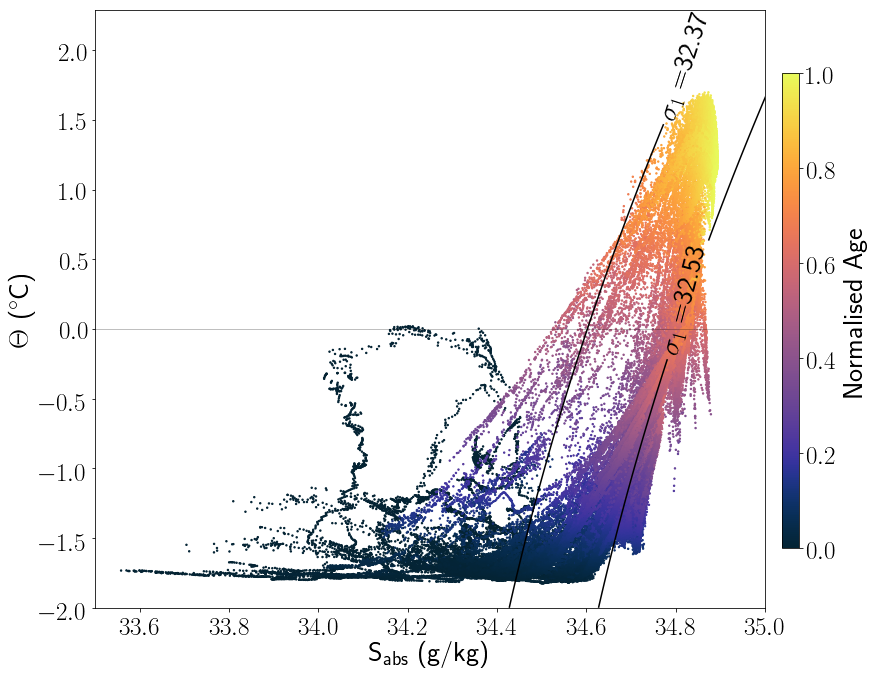

In [21]:
fig = plt.figure(num=1,figsize=(12,11))
ax1 = fig.subplots()
plot = ax1.scatter(salt_along_isobath,temp_along_isobath,c = normalised_age, cmap = cmo.thermal, s = 2)
levels = [32.37,32.53]
sigma_plot = ax1.contour(AS1, CT1,SIGMA_1,levels = levels, colors = 'k', linewidth = 0.5)
plt.clabel(sigma_plot, fmt = '$\sigma_1 = $%1.2f', fontsize = 28)
ax1.set_ylabel(r'$\Theta$ ($^\circ$C)', fontsize = 28)
ax1.plot([33.5,35],[0,0],'k',linewidth=0.5, alpha = 0.5)
ax1.set_xlabel(r'S$_\text{abs}$ (g/kg) ', fontsize = 28)
ax1.set_xlim([33.5,35.0])
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Normalised Age', fontsize = 28)
plt.show()

These density criterion are used to distiguish DSW, CDW, AASW (in order of decreasing density). DSW category is based on the density of the turning point (switching from net offshore to net onshore) of the circumpolar mean cross isobath volume transport integrated from high to low density. The CDW density is based on the TS plot, attempting to incorporate older waters.

In [22]:
DSW_trans = vol_trans_isobath_mean_8485.sel(isopycnal_bins = slice(DSW_8485_density,None)).sum(dim = 'isopycnal_bins').cumsum(dim = 'isobath_index').load()/1e6
CDW_trans = vol_trans_isobath_mean_8485.sel(isopycnal_bins = slice(32.37,DSW_8485_density)).sum(dim = 'isopycnal_bins').cumsum(dim = 'isobath_index').load()/1e6
AASW_trans = vol_trans_isobath_mean_8485.sel(isopycnal_bins = slice(None,32.37)).sum(dim = 'isopycnal_bins').cumsum(dim = 'isobath_index').load()/1e6
total_trans = vol_trans_isobath_mean_8485.sum(dim = 'isopycnal_bins').cumsum(dim = 'isobath_index').load()/1e6

In [26]:
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land

In [29]:
def offshore_transport_sum(ax):
    ax.plot(net_offshore_trans_8485,isopycnal_bins,color = 'k', linewidth = 2, label = 'Control')
    ax.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 28)
    ax.set_xlabel(r'Offshore transport (Sv)', fontsize = 28)
    ax.plot([0,0],[30,32.8],'k',linewidth=0.5, alpha = 0.5)
    ax.plot([-2,12],[DSW_8485_density, DSW_8485_density],'k',linewidth=0.5)
    ax.plot([-2,12],[32.37, 32.37],'k',linewidth=0.5)
    ax.set_xlim((-0.5,11))
    ax.set_ylim((32.8,31.6))
    ax.set_xticks([0,2,4,6,8,10])
    ax.text(9,32.7, 'DSW', fontsize = 28, color = 'purple')
    ax.text(9,32.45, 'CDW', fontsize = 28, color = 'tomato')    
    ax.text(8.4,32.3, 'AASW', fontsize = 28, color = 'royalblue')    

In [36]:
def offshore_transport(ax):
    ax.fill_between([698,1850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    ax.fill_between([3460,4300],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    ax.fill_between([5524,5850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)

    ax.plot(isobath_index_array, total_trans, color = 'k', linewidth = 1,label = 'Total')
    ax.plot(isobath_index_array, AASW_trans, color = 'royalblue', linewidth = 2,label = 'AASW')
    ax.plot(isobath_index_array, CDW_trans, color = 'tomato', linewidth = 2,label = 'CDW')
    ax.plot(isobath_index_array, DSW_trans, color = 'purple', linewidth = 2,label = 'DSW')

    ax.set_ylabel('Offshore transport (Sv)', fontsize = 28)
    ax.set_xlabel('Isobath Index', fontsize = 28)
    ax.plot([0,isobath_index_array[-1]],[0,0],'gray',linewidth=0.5)


    ax.set_xlim((0,isobath_index_array[-1]))
    ax.set_yticks([-8,-6,-4,-2,0,2,4,6,8,10])
    ax.set_ylim((-8.2,11.2))
    ax.legend(loc=2, fontsize = 24)
    ax.set_xticks([0,1000,2000,3000,4000,5000,6000])

In [27]:
ht = cc.querying.getvar(expt,'ht', session, ncfile ='ocean_grid.nc', n=1)
ht = ht.sel(yt_ocean = slice(-90,-59))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf, shelf_map  = shelf_mask_isobath(ht)

In [28]:
def isobath_index_map(ax1):
    norm1 = col.Normalize(vmin=0,vmax=1050)    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax1.contour(xt_ocean, yt_ocean,shelf_map,[0,1], colors = 'k', linewidth = 1, alpha = 0.6, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[698], lat_along_isobath[698],marker='o', color='k', markersize=4,transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[1850], lat_along_isobath[1850],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[1306], lat_along_isobath[1306],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[3460], lat_along_isobath[3460],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[4300], lat_along_isobath[4300],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[5524], lat_along_isobath[5524],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())
    ax1.plot(lon_along_isobath[5850], lat_along_isobath[5850],marker='o', color='k', markersize=4, transform=ccrs.PlateCarree())

    ## add 0 location
    ax1.plot(lon_along_isobath[0], lat_along_isobath[0],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=25)
    ax1.text(lon_along_isobath[0], lat_along_isobath[0], '0', verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 25)

    ## add 1000 location
    ax1.plot(lon_along_isobath[1000], lat_along_isobath[1000],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=25, y=-25)
    ax1.text(lon_along_isobath[1000], lat_along_isobath[1000], '1000',verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 25)

    ## add 2000 location
    ax1.plot(lon_along_isobath[2000], lat_along_isobath[2000],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=-15, y=-10)
    ax1.text(lon_along_isobath[2000], lat_along_isobath[2000], '2000',verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 25)

    ## add 3000 location
    ax1.plot(lon_along_isobath[3000], lat_along_isobath[3000],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=-15, y=-10)
    ax1.text(lon_along_isobath[3000], lat_along_isobath[3000], '3000',verticalalignment='center', horizontalalignment='right', transform=text_transform, fontsize = 25)

    ## add 4000 location
    ax1.plot(lon_along_isobath[4000], lat_along_isobath[4000],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=35, y=25)
    ax1.text(lon_along_isobath[4000], lat_along_isobath[4000], '4000', verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 25)

    ## add 5000 location
    ax1.plot(lon_along_isobath[5000], lat_along_isobath[5000],marker='o', color='black', markersize=12,transform=ccrs.PlateCarree())
    transform = ccrs.PlateCarree()._as_mpl_transform(ax1)
    text_transform = offset_copy(transform, units='dots', x=35, y=25)
    ax1.text(lon_along_isobath[5000], lat_along_isobath[5000], '5000',verticalalignment='center', horizontalalignment='right',transform=text_transform, fontsize = 25)

    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax1.outline_patch.set_visible(False)

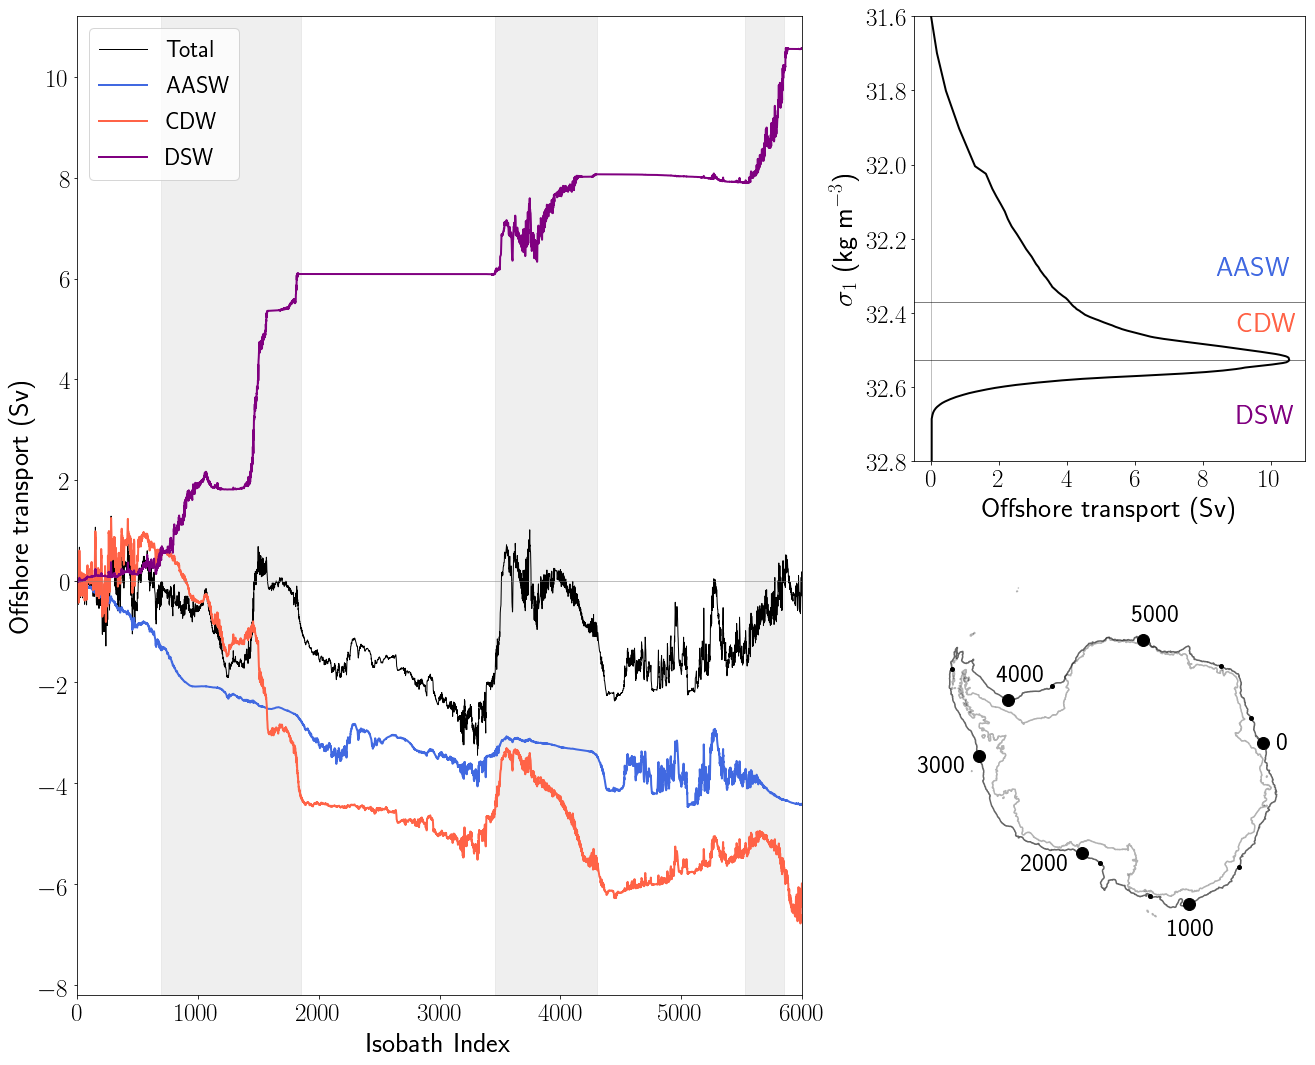

In [43]:
fig = plt.figure(num=1,figsize=(22,18))
gs = gridspec.GridSpec(2,2, width_ratios=[13,7]) 
ax0, ax1, ax2 = plt.subplot(gs[:,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,1],projection=ccrs.SouthPolarStereo())
# gs.update(hspace = 0.4)
offshore_transport(ax0)
offshore_transport_sum(ax1)
isobath_index_map(ax2)
plt.show()